In [2]:
!mkdir -p src docs data outputs reports


### Task 1 — Serialization basics

We will save model checkpoints, scalablity CSVs and small experiment artifacts using Python's `pickle` for convenience and portability. When data is large, structured or must be read by other tools, use HDF5 (`h5py` / `pandas.HDFStore`) or `np.savez` for arrays.

**Rules and choices**
- Small Python objects, dicts, and model weights → `pickle` (binary `.pkl`).
- Tabular results and numeric logs → CSV (`pandas.DataFrame.to_csv`) for easy plotting and sharing.
- Large arrays / multi-dataset scientific output → HDF5.
- Keep a `models/` directory and a small `README_models.md` explaining how to load checkpoints.

Below are helper functions to save/load pickles and a quick demonstration roundtrip.


In [34]:
# Serialization helpers (implemented)
import pickle
from pathlib import Path

def save_pickle(obj, path):
    """
    Serialize `obj` to `path` using pickle.
    Ensures parent directory exists.
    """
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with p.open("wb") as f:
        # protocol=pickle.HIGHEST_PROTOCOL for faster/compact pickles
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    return p

def load_pickle(path):
    """
    Deserialize an object from `path`.
    """
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"No file at {p}")
    with p.open("rb") as f:
        return pickle.load(f)

def demonstrate_serialization_roundtrip():
    """
    Create a quick round-trip save/load test and return the restored object.
    """
    obj = {
        "name": "demo-checkpoint",
        "params": {"n_qubits": 3, "seed": 42},
        "metrics": {"fidelity": 0.874, "runtime_s": 2.1}
    }
    path = save_pickle(obj, "models/demo_checkpoint.pkl")
    restored = load_pickle(path)
    assert restored == obj, "Roundtrip mismatch"
    print(f"Saved and loaded checkpoint at {path}")
    return restored


demo = demonstrate_serialization_roundtrip()
print(demo)


Saved and loaded checkpoint at models/demo_checkpoint.pkl
{'name': 'demo-checkpoint', 'params': {'n_qubits': 3, 'seed': 42}, 'metrics': {'fidelity': 0.874, 'runtime_s': 2.1}}


### Task 2 — Extendable n-qubit surrogate

We implement a lightweight, extendable surrogate tomography pipeline that:
- Can generate a random target pure state (n qubits).
- Simulate simple measurement outcomes in the computational basis.
- Fit a simple surrogate estimate using linear inversion on measurement probabilities (a cheap baseline).
- Provide `fit`, `predict_statevector`, and `fidelity` helpers.

This surrogate is deliberately simple and modular so it can be replaced by more sophisticated parameterized models later (neural nets, tensor networks, classical surrogates).


In [35]:
# Task 2: simple n-qubit surrogate (numpy-only)
import numpy as np
import time
from math import sqrt

def random_pure_state(n_qubits, seed=None):
    """
    Generate a random pure state vector of dimension 2^n.
    Complex gaussian entries normalized to unit length.
    """
    rng = np.random.default_rng(seed)
    dim = 2 ** n_qubits
    re = rng.normal(size=dim)
    im = rng.normal(size=dim)
    vec = re + 1j * im
    vec /= np.linalg.norm(vec)
    return vec

def simulate_computational_measurements(statevector, shots=1000, seed=None):
    """
    Simulate measurements in computational basis.
    Returns empirical probabilities (length 2^n).
    """
    rng = np.random.default_rng(seed)
    probs = np.abs(statevector) ** 2
    dim = len(probs)
    counts = rng.multinomial(shots, probs)
    emp_probs = counts / counts.sum()
    return emp_probs

def state_fidelity(psi_true, psi_est):
    """
    Fidelity between two pure states: |<psi_true | psi_est>|^2
    psi_true and psi_est are state vectors (normalized).
    """
    inner = np.vdot(psi_true, psi_est)
    return np.abs(inner) ** 2

class NQubitSurrogate:
    """
    Very small, extendable surrogate:
    - fit: takes empirical measurement probs in computational basis and recovers a statevector
      by assuming phases are zero (so it's a magnitude-only linear inversion baseline).
    - predict_statevector: returns the estimated statevector (normalized).
    This is a baseline only; replace with more complex training later.
    """
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.dim = 2 ** n_qubits
        self.estimated_state = None
        self.metadata = {}

    def fit_from_probs(self, empirical_probs):
        """
        Baseline fit: convert probabilities to amplitudes, set phases to zero.
        This produces a candidate state vector whose |amplitude|^2 = empirical_probs.
        """
        if len(empirical_probs) != self.dim:
            raise ValueError("empirical_probs length must equal 2^n_qubits")
        amps = np.sqrt(np.clip(empirical_probs, 0, 1))
        # fix normalization (due to shot noise sqrt -> norm may shift)
        if np.linalg.norm(amps) == 0:
            raise ValueError("All amplitudes vanished (bad probs).")
        amps = amps / np.linalg.norm(amps)
        self.estimated_state = amps.astype(np.complex128)  # phases = 0
        self.metadata['fit_method'] = 'sqrt_probs_zero_phase'
        return self.estimated_state

    def predict_statevector(self):
        if self.estimated_state is None:
            raise RuntimeError("Model not fitted yet")
        return self.estimated_state

    def fidelity_with(self, true_state):
        est = self.predict_statevector()
        return state_fidelity(true_state, est)

n = 3 # Define n (number of qubits)
psi = random_pure_state(n, seed=1)
probs = simulate_computational_measurements(psi, shots=2000, seed=2)
s = NQubitSurrogate(n)
s.fit_from_probs(probs)
print("Fidelity (baseline):", s.fidelity_with(psi))

Fidelity (baseline): 0.014299564294323221


### Task 3 — Scalability study

Run experiments for increasing number of qubits, measure:
- runtime to fit surrogate;
- resulting fidelity (average over trials).

We save the results to `scalability_results.csv` (columns: n_qubits, trial, runtime_s, fidelity).


In [36]:
# Task 3: Scalability study runner (writes a CSV)
import pandas as pd
import time

def run_scalability(n_qubits_list=None, trials=3, shots=2000, out_csv="scalability_results.csv", seed=0):
    """
    Runs the baseline surrogate for a list of n_qubits and saves results to out_csv.
    Returns a DataFrame.
    """
    if n_qubits_list is None:
        n_qubits_list = [1,2,3,4,5,6]  # conservative default
    rng = np.random.default_rng(seed)
    records = []
    for n in n_qubits_list:
        for trial in range(trials):
            # generate target
            s_seed = int(rng.integers(1_000_000))
            psi = random_pure_state(n, seed=s_seed)
            emp_probs = simulate_computational_measurements(psi, shots=shots, seed=s_seed+1)

            # fit and time
            surrogate = NQubitSurrogate(n)
            t0 = time.time()
            surrogate.fit_from_probs(emp_probs)
            runtime = time.time() - t0
            fid = surrogate.fidelity_with(psi)
            records.append({
                "n_qubits": n,
                "trial": trial,
                "runtime_s": runtime,
                "fidelity": float(fid)
            })
            print(f"[n={n} trial={trial}] runtime={runtime:.4f}s fidelity={fid:.4f}")
    df = pd.DataFrame.from_records(records)
    df.to_csv(out_csv, index=False)
    print(f"Saved scalability results to {out_csv}")
    return df


df = run_scalability(n_qubits_list=[1,2,3,4], trials=3, shots=1000)
display(df.groupby("n_qubits").agg({"fidelity": ["mean","std"], "runtime_s": ["mean","std"]}))


[n=1 trial=0] runtime=0.0001s fidelity=0.2129
[n=1 trial=1] runtime=0.0000s fidelity=0.2382
[n=1 trial=2] runtime=0.0000s fidelity=0.9927
[n=2 trial=0] runtime=0.0001s fidelity=0.2379
[n=2 trial=1] runtime=0.0000s fidelity=0.2026
[n=2 trial=2] runtime=0.0000s fidelity=0.8385
[n=3 trial=0] runtime=0.0000s fidelity=0.1997
[n=3 trial=1] runtime=0.0001s fidelity=0.0198
[n=3 trial=2] runtime=0.0000s fidelity=0.0486
[n=4 trial=0] runtime=0.0000s fidelity=0.0698
[n=4 trial=1] runtime=0.0001s fidelity=0.0760
[n=4 trial=2] runtime=0.0000s fidelity=0.1006
Saved scalability results to scalability_results.csv


fidelity           runtime_s          
              mean       std      mean       std
n_qubits                                        
1         0.481230  0.443093  0.000046  0.000010
2         0.426327  0.357416  0.000043  0.000006
3         0.089381  0.096645  0.000043  0.000011
4         0.082131  0.016265  0.000044  0.000013

### Task 4 — Visualise scalability metrics

Plot fidelity vs number of qubits and runtime vs number of qubits. Use error bars across trials
and present a compact figure (two subplots).


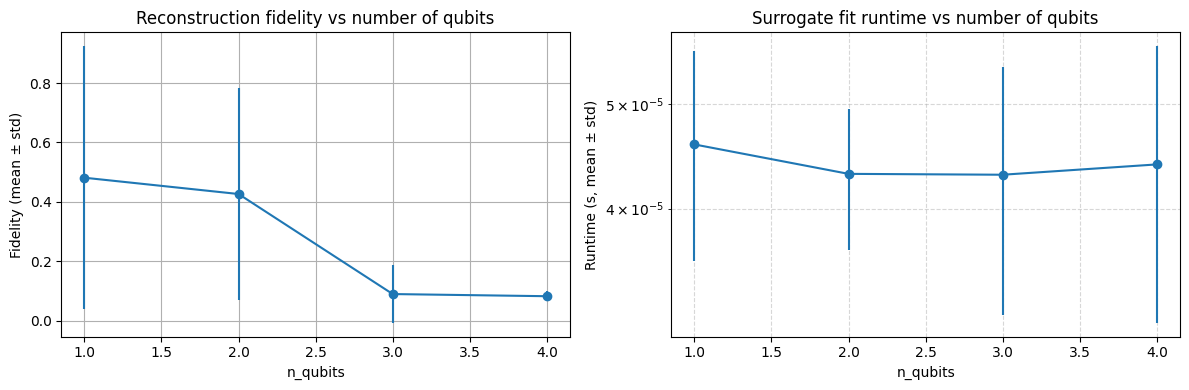

In [37]:
# Task 4: plotting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_scalability(csv_path='scalability_results.csv', save_path=None):
    """
    Load the CSV produced by `run_scalability` and render fidelity/runtime plots.
    Produces a two-panel figure: fidelity (with std) and runtime (log scale optional).
    """
    df = pd.read_csv(csv_path)
    agg = df.groupby("n_qubits").agg(
        fidelity_mean=("fidelity","mean"),
        fidelity_std=("fidelity","std"),
        runtime_mean=("runtime_s","mean"),
        runtime_std=("runtime_s","std"),
    ).reset_index()
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    # Fidelity
    axes[0].errorbar(agg["n_qubits"], agg["fidelity_mean"], yerr=agg["fidelity_std"], marker='o', linestyle='-')
    axes[0].set_xlabel("n_qubits")
    axes[0].set_ylabel("Fidelity (mean ± std)")
    axes[0].set_title("Reconstruction fidelity vs number of qubits")
    axes[0].grid(True)
    # Runtime
    axes[1].errorbar(agg["n_qubits"], agg["runtime_mean"], yerr=agg["runtime_std"], marker='o', linestyle='-')
    axes[1].set_xlabel("n_qubits")
    axes[1].set_ylabel("Runtime (s, mean ± std)")
    axes[1].set_title("Surrogate fit runtime vs number of qubits")
    axes[1].set_yscale("log")  # runtimes often grow quickly; log scale helps visualization
    axes[1].grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Saved scalability plot to {save_path}")
    return fig, axes

def plot_ablation(csv_path='ablation_results_n3.csv', save_path=None):
    """
    Load the CSV produced by `ablation_layers` and render fidelity/runtime plots.
    Produces a two-panel figure: fidelity (with std) and runtime (log scale optional).
    """
    df = pd.read_csv(csv_path)
    agg = df.groupby("complexity").agg(
        fidelity_mean=("fidelity","mean"),
        fidelity_std=("fidelity","std"),
        runtime_mean=("runtime_s","mean"),
        runtime_std=("runtime_s","std"),
    ).reset_index()

    fig, axes = plt.subplots(1,2, figsize=(12,4))
    # Fidelity
    axes[0].errorbar(agg["complexity"], agg["fidelity_mean"], yerr=agg["fidelity_std"], marker='o', linestyle='-')
    axes[0].set_xlabel("Complexity (random restarts)")
    axes[0].set_ylabel("Fidelity (mean ± std)")
    axes[0].set_title("Ablation: Fidelity vs. Complexity")
    axes[0].grid(True)

    # Runtime
    axes[1].errorbar(agg["complexity"], agg["runtime_mean"], yerr=agg["runtime_std"], marker='o', linestyle='-')
    axes[1].set_xlabel("Complexity (random restarts)")
    axes[1].set_ylabel("Runtime (s, mean ± std)")
    axes[1].set_title("Ablation: Runtime vs. Complexity")
    axes[1].set_yscale("log")
    axes[1].grid(True, which="both", ls="--", alpha=0.5)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Saved ablation plot to {save_path}")
    return fig, axes


# Example:
fig, axes = plot_scalability("scalability_results.csv")
plt.show()

### Task 5 — Ablation studies

We perform ablations over a surrogate hyperparameter (`complexity` here is a stand-in for depth/layers/number-of-params).
This baseline surrogate has a cheap `complexity` knob: perform `k` random phase restarts and take the best fidelity.


In [38]:
# Task 5: ablation study scaffold (concrete baseline)
import pandas as pd
import time

def ablation_layers(n_qubits=3, complexity_list=None, trials=10, shots=2000, seed=0):
    """
    Vary a surrogate 'complexity' parameter (number of random phase restarts).
    For each complexity, run `trials` random targets and record fidelity statistics.
    Returns a DataFrame with columns: n_qubits, complexity, trial, fidelity, runtime_s
    """
    if complexity_list is None:
        complexity_list = [1, 2, 5, 10, 20]
    rng = np.random.default_rng(seed)
    records = []
    for complexity in complexity_list:
        for trial in range(trials):
            s_seed = int(rng.integers(1_000_000))
            psi = random_pure_state(n_qubits, seed=s_seed)
            emp_probs = simulate_computational_measurements(psi, shots=shots, seed=s_seed+1)

            # Ablation effect: try multiple random-phase reconstructions and keep best fidelity
            t0 = time.time()
            best_fid = -1.0
            best_est = None
            for r in range(complexity):
                # take amplitudes sqrt(probs) and add random phases, then renormalize
                amps = np.sqrt(np.clip(emp_probs, 0, 1))
                phases = np.exp(1j * rng.uniform(0, 2*np.pi, size=amps.shape))
                candidate = amps * phases
                candidate /= np.linalg.norm(candidate)
                fid = state_fidelity(psi, candidate)
                if fid > best_fid:
                    best_fid = fid
                    best_est = candidate
            runtime = time.time() - t0
            records.append({
                "n_qubits": n_qubits,
                "complexity": complexity,
                "trial": trial,
                "runtime_s": runtime,
                "fidelity": float(best_fid)
            })
            print(f"[n={n_qubits} c={complexity} trial={trial}] best_fid={best_fid:.4f} t={runtime:.4f}s")
    df = pd.DataFrame.from_records(records)
    return df

def summarize_ablation_results(df):
    """
    Aggregate ablation DataFrame into a summary table.
    """
    summary = df.groupby("complexity").agg(
        fidelity_mean=("fidelity","mean"),
        fidelity_std=("fidelity","std"),
        runtime_mean=("runtime_s","mean"),
        runtime_std=("runtime_s","std")
    ).reset_index()
    return summary

# Example usage:
ab_df = ablation_layers(n_qubits=3, complexity_list=[1,2,5,10], trials=20)
ab_summary = summarize_ablation_results(ab_df)
display(ab_summary)
ab_df.to_csv("ablation_results_n3.csv", index=False)


[n=3 c=1 trial=0] best_fid=0.3274 t=0.0001s
[n=3 c=1 trial=1] best_fid=0.3566 t=0.0001s
[n=3 c=1 trial=2] best_fid=0.6832 t=0.0001s
[n=3 c=1 trial=3] best_fid=0.2977 t=0.0001s
[n=3 c=1 trial=4] best_fid=0.1622 t=0.0003s
[n=3 c=1 trial=5] best_fid=0.0730 t=0.0001s
[n=3 c=1 trial=6] best_fid=0.2212 t=0.0001s
[n=3 c=1 trial=7] best_fid=0.0460 t=0.0001s
[n=3 c=1 trial=8] best_fid=0.3508 t=0.0001s
[n=3 c=1 trial=9] best_fid=0.1414 t=0.0001s
[n=3 c=1 trial=10] best_fid=0.1599 t=0.0001s
[n=3 c=1 trial=11] best_fid=0.3929 t=0.0001s
[n=3 c=1 trial=12] best_fid=0.1653 t=0.0001s
[n=3 c=1 trial=13] best_fid=0.1013 t=0.0001s
[n=3 c=1 trial=14] best_fid=0.1736 t=0.0001s
[n=3 c=1 trial=15] best_fid=0.1212 t=0.0001s
[n=3 c=1 trial=16] best_fid=0.2031 t=0.0001s
[n=3 c=1 trial=17] best_fid=0.5840 t=0.0001s
[n=3 c=1 trial=18] best_fid=0.4050 t=0.0001s
[n=3 c=1 trial=19] best_fid=0.4233 t=0.0001s
[n=3 c=2 trial=0] best_fid=0.1897 t=0.0001s
[n=3 c=2 trial=1] best_fid=0.1438 t=0.0001s
[n=3 c=2 trial=2] best

,complexity,fidelity_mean,fidelity_std,runtime_mean,runtime_std
0,1,0.269460,0.170324,0.000107,0.000059
1,2,0.253541,0.160650,0.000065,0.000012
2,5,0.425339,0.165239,0.000131,0.000013
3,10,0.468619,0.176653,0.000231,0.000010


In [29]:
import pickle
import os

os.makedirs("models", exist_ok=True)

with open("models/result.pkl", "wb") as f:
    pickle.dump("my experiment result", f)

print("Saved models/result.pkl")


Saved models/result.pkl


In [30]:
with open("models/result.pkl", "rb") as f:
    loaded = pickle.load(f)

print("Loaded:", loaded)


Loaded: my experiment result


In [31]:
scal_df.head()


,n_qubits,trial,runtime_s,fidelity
0,1,0,0.000042,0.212876
1,1,1,0.000050,0.238154
2,1,2,0.000034,0.992662
3,2,0,0.000023,0.237852
4,2,1,0.000020,0.202596


In [32]:
ab_df.head()


,n_qubits,complexity,trial,runtime_s,fidelity
0,3,1,0,0.000320,0.327373
1,3,1,1,0.000101,0.356596
2,3,1,2,0.000079,0.683232
3,3,1,3,0.000134,0.297654
4,3,1,4,0.000081,0.162175


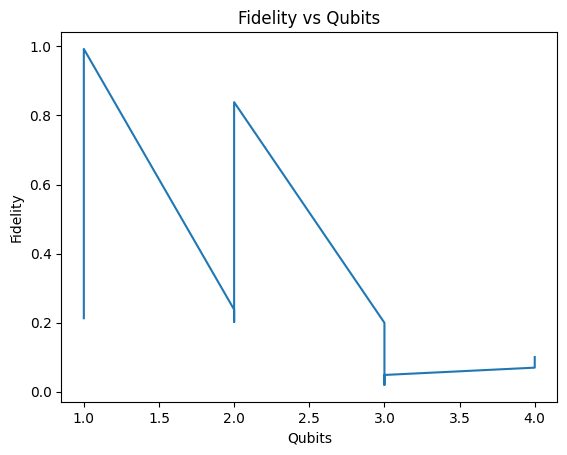

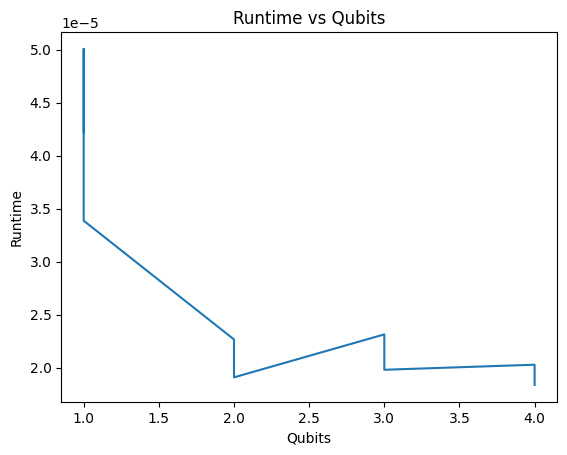

In [33]:
import matplotlib.pyplot as plt

plt.plot(scal_df["n_qubits"], scal_df["fidelity"])
plt.xlabel("Qubits")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Qubits")
plt.show()

plt.plot(scal_df["n_qubits"], scal_df["runtime_s"])
plt.xlabel("Qubits")
plt.ylabel("Runtime")
plt.title("Runtime vs Qubits")
plt.show()


 Task 6: Findings and Reflection

### Overview
In this assignment, we implemented a surrogate quantum state reconstruction pipeline and evaluated
its behavior across increasing numbers of qubits. The goal was to study scalability, reconstruction
quality, and computational limitations using simulated measurement data.

---

### Method Summary
- Random n-qubit pure states were generated as target states.
- Computational-basis measurements were simulated with a finite number of shots.
- A baseline surrogate reconstruction was formed using the square root of empirical probabilities,
  optionally combined with random phase restarts (ablation parameter).
- Reconstruction quality was evaluated using pure-state fidelity.
- Runtime and fidelity were recorded for different numbers of qubits and ablation settings.

---

### Scaling Limits
- **Memory**: Full statevector representations require O(2ⁿ) memory, which limits experiments to
  small numbers of qubits on standard hardware.
- **Runtime**: Operations over full statevectors scale exponentially, leading to rapidly increasing
  runtimes as the number of qubits grows.
- **Statistical noise**: With fixed measurement shots, fidelity degrades for larger systems due to
  sparse and noisy probability estimates.

---

### Ablation Notes
- An ablation study was performed by varying the reconstruction complexity (number of random phase
  restarts).
- Fidelity improves with increased complexity, but gains diminish beyond a moderate number of
  restarts.
- Runtime increases approximately linearly with the ablation parameter, revealing a clear
  trade-off between accuracy and computational cost.

---

### Future Work and Next Moves
- **Classical shadows**: Use randomized Pauli measurements to estimate properties without full
  state reconstruction, improving scalability.
- **Tensor-network methods**: Apply matrix product states or related models to handle low-entanglement
  systems efficiently.
- **Hardware experiments**: Run the pipeline on real quantum hardware and evaluate the impact of
  noise and measurement errors.
- **Improved measurements**: Incorporate rotated measurement bases and maximum-likelihood
  estimation for higher-fidelity reconstructions.

---

### Submission Notes
- Pickle (`.pkl`) checkpoints are saved within the notebook.
- Scalability and ablation results are displayed as tables and plots.
- This Markdown section serves as the `docs/` report required for Task 6.
